# Neural Network :Part-3  Building L Layer Image Classifier 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import imageio
from datetime import datetime


plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

## L-layer neural network - Outline

- Initialize the parameters for a two-layer network and for an $L$-layer neural network.
- Forward propagation .
     - [LINEAR->ACTIVATION] forward propagation step (resulting in $Z^{[l]}$) using ACTIVATION function (relu/sigmoid).
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$).
- Compute the loss.
- Implement the backward propagation module.
    - Complete the [LINEAR->ACTIVATION] backward function using gradient of the ACTIVATE function relu_backward /sigmoid_backward).
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

For every forward function, there is a corresponding backward function. At every step of your forward module there will be some values in a cache. The cached values are useful for computing gradients. In the backpropagation module  use the cache to calculate the gradients. 

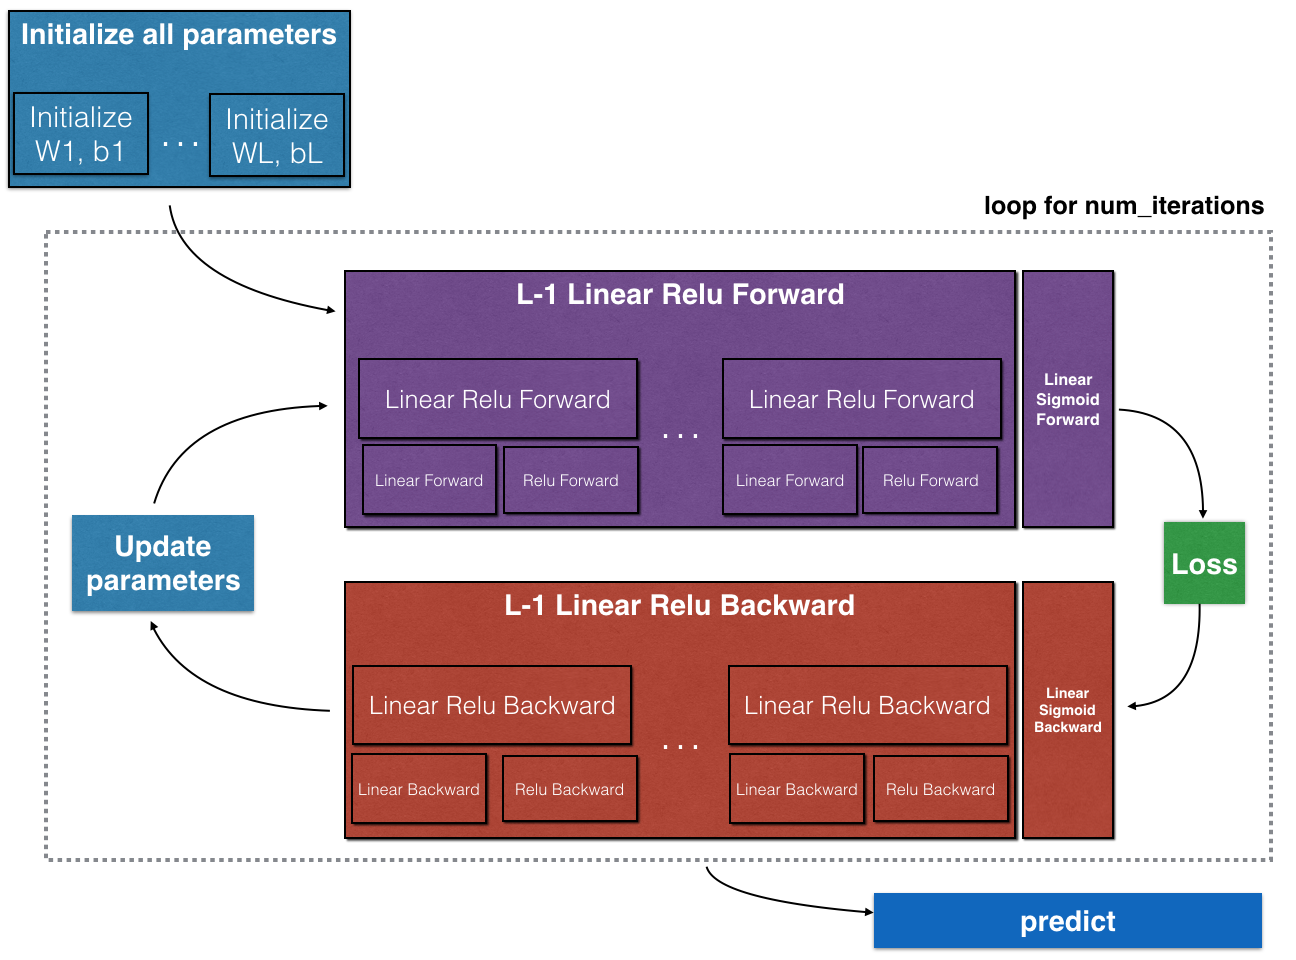

###  Initialization for L-layer Neural Network

- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. i.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.

Example of initialization for a deeper L-layer neural network if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td >  </td> 
        <td width="15%"><b>Shape of W</b></td> 
        <td width="15%"><b>Shape of b</b></td> 
        <td width="30%"><b>Activation</b></td>
        <td width="30%"><b>Shape of Activation</b></td> 
    <tr>
    <tr>
        <td><b>Layer 1</b></td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td><b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
    <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
   <tr>
        <td><b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
   <tr>
        <td><b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>
</table>

Compute $W X + b$ in python, it carries out broadcasting. 

For example, if $ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$  then 

$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$

In [2]:
def initialize_parameters_deep(layer_dims):    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    
        
    return parameters

## Forward propagation
   Model is [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID 
   
- LINEAR Farward
The linear forward computes $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$ where $A^{[0]} = X$
- ACTIVATION Forward where ACTIVATION will be either ReLU or Sigmoid. 
- "[LINEAR->ACTIVATION]" forward : Group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION) because in deep learning, the linear forward step and activation step is counted as a single layer in the neural network, not two layers.

$$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$
 where the activation "g" can be **sigmoid** or **relu**.

### Linear Forward 

In [3]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b) 
    return Z, cache

### Activation Forward

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \displaystyle \frac{1}{ 1 + e^{-(W A + b)}}$. 

In [4]:
def sigmoid(Z):   
    A = 1/(1+np.exp(-Z))
    cache = Z  
    return A, cache

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. 

In [5]:
def relu(Z):    
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

### Linear Activation Forward 

In [6]:
def linear_activation_forward(A_prev, W, b, activation): # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

### L-Layer Model Forward
A function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

$\hat{Y}$ = $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$

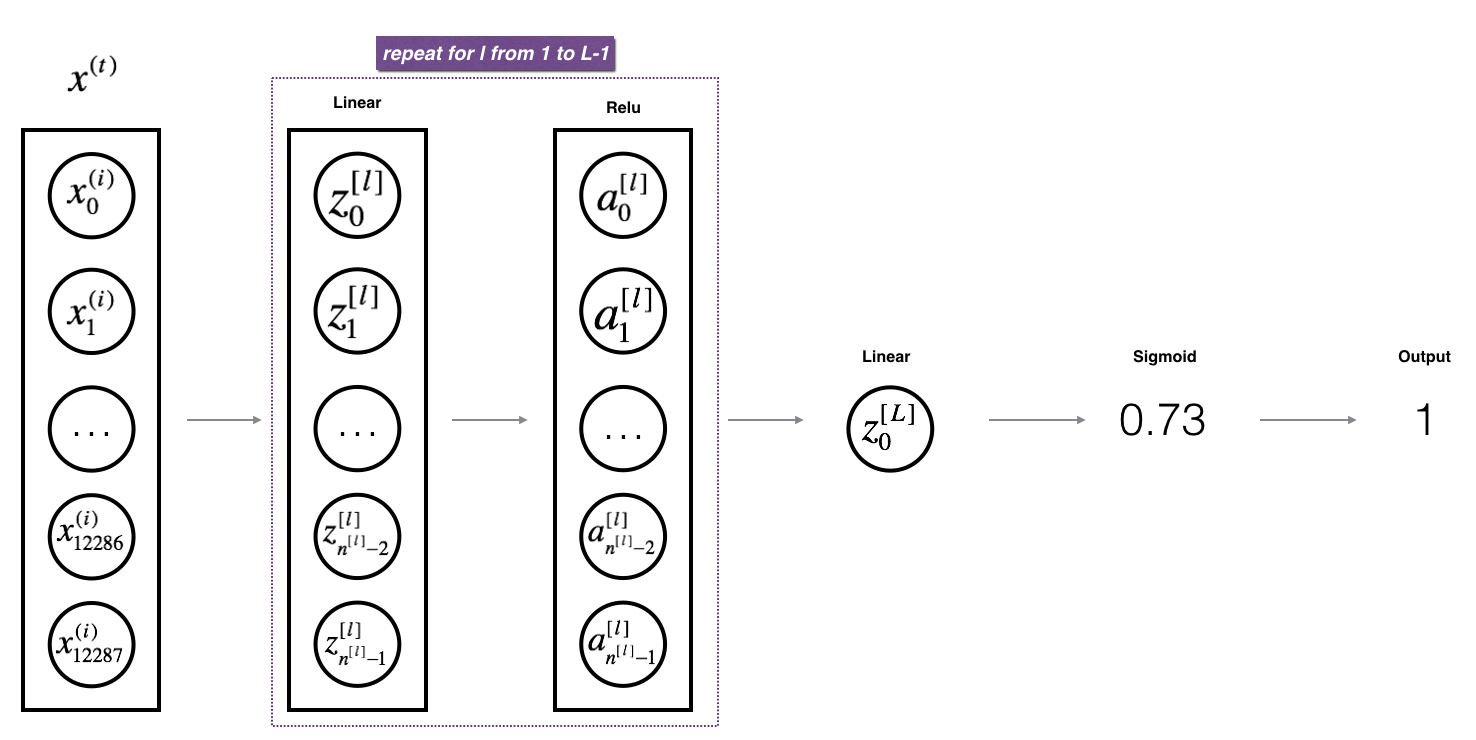

In [7]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)            
    return AL, caches

## Cost/Loss function
 Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [8]:
def compute_cost(AL, Y):   
    m = Y.shape[1]
    cost = (-1/m) * np.sum( np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T) )
    cost = np.squeeze(cost)
    return cost

## Backward propagation module
Similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)
- Update Parameters

 
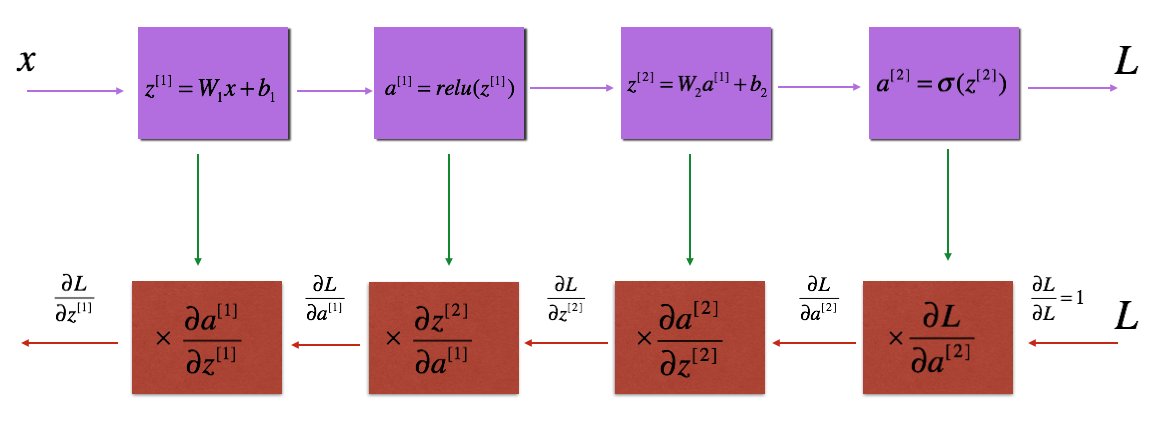

The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}}$$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why it is called **backpropagation**.

### Linear backward


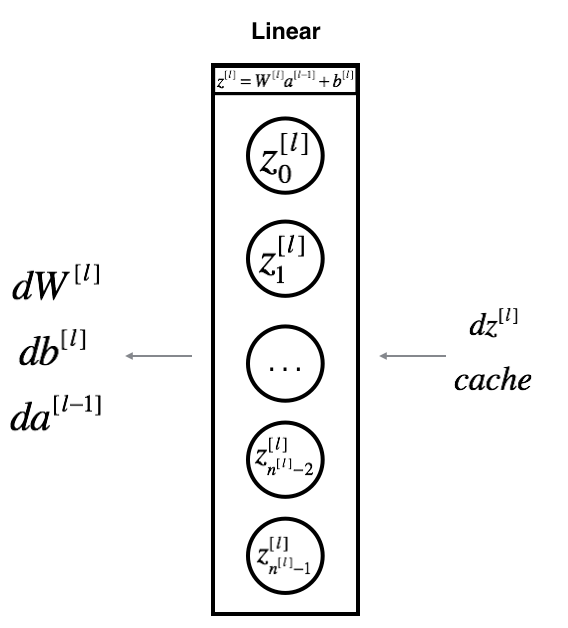



For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

In [9]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)
  
    return dA_prev, dW, db

### Activation backward
- **`sigmoid_backward`**

In [10]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

- **`relu_backward`**

In [11]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0 # When z <= 0, you should set dz to 0 as well.   
    return dZ

### Linear-Activation backward

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$. 
```python
dZ = sigmoid_backward(dA, activation_cache)
```
```python
dZ = relu_backward(dA, activation_cache)
```

In [12]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)       
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
    return dA_prev, dW, db

### L-Model Backward 

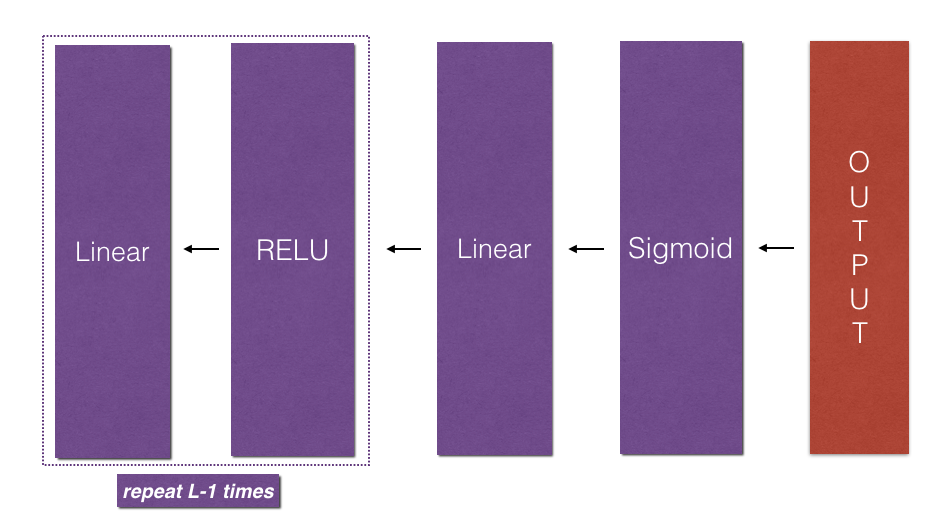


To backpropagate through this network, we know that the output is, 
$$A^{[L]} = \sigma(Z^{[L]})$$. 

compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use following formula (derived using calculus):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. Feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use following formula : 

$$grads["dW" + str(l)] = dW^{[l]} $$


In [13]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, 
                                                                                                  current_cache, 
                                                                                                  "sigmoid")
    dZ = AL - Y
    linear_cache, activation_cache = current_cache
    A_prev, W, b=linear_cache      
    grads["dW" + str(L)] = (1/m) * np.dot(dZ, A_prev.T)
    grads["db" + str(L)] = (1/m) * np.sum(dZ, axis =1, keepdims = True)
    grads["dA" + str(L)] = np.dot(W.T, dZ)
    
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
  
    return grads

### Update Parameters
Update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [14]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
       
    return parameters

## Architecture of Model

### L-layer Deep Neural Network
The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***

<u>Detailed Architecture of Model</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).


For example, if $ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    [R_{1,1},G_{1,1},B_{1,1}]  & [R_{1,2},G_{1,2},B_{1,2}] &\hot & [R_{1,64},G_{1,64},B_{1,64}]\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$



- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

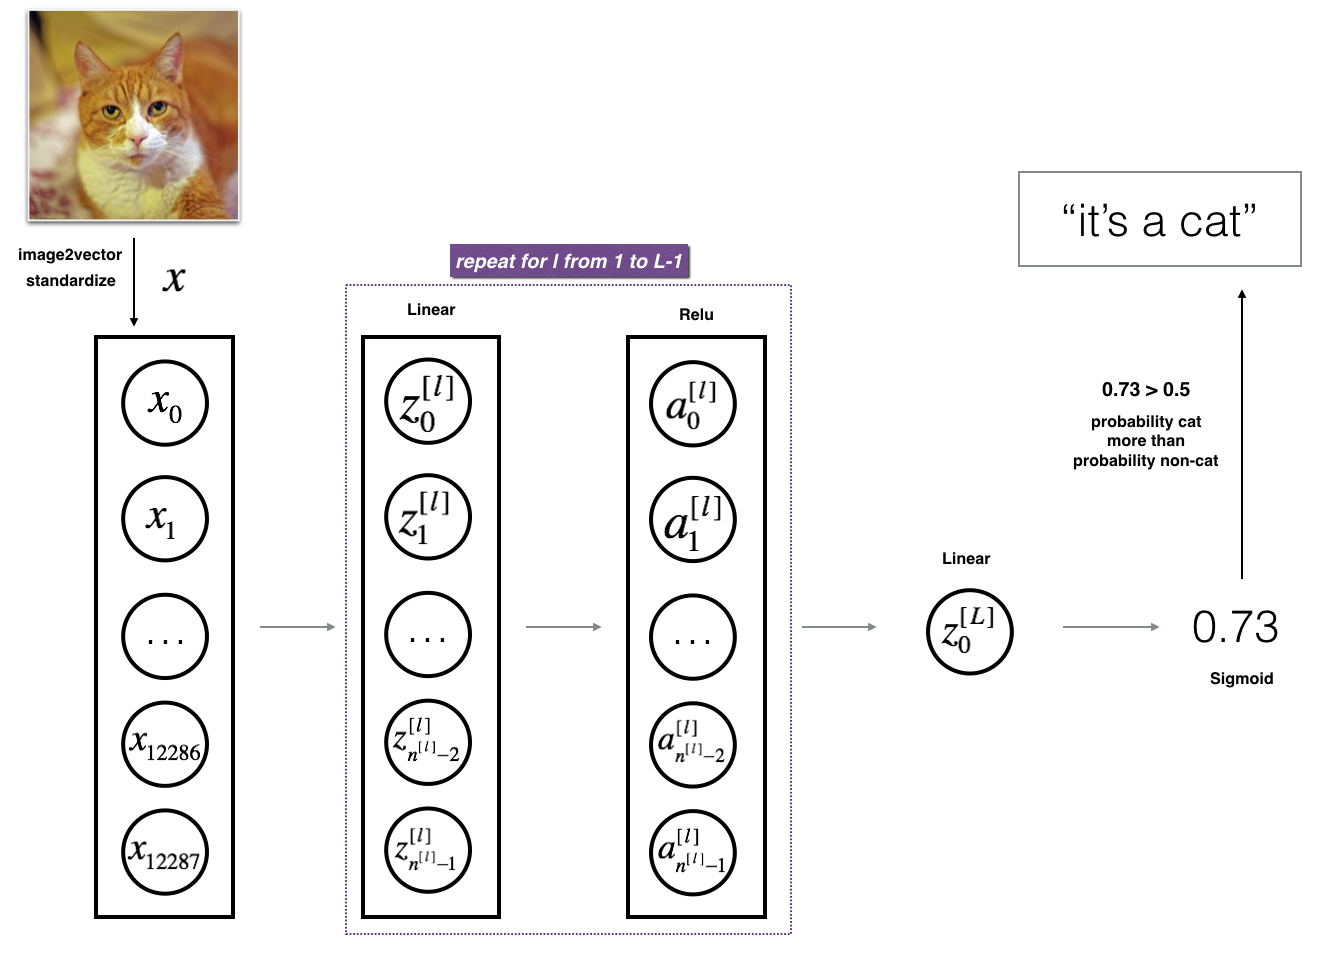

In [15]:
def model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
         
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
            
    parameters["costs"]=costs
    parameters["learning_rate"]=learning_rate
    
    
    return parameters

# ---------------------------------------------

# Using Model

# ---------------------------------------------

## Load Dataset ##

A dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [18]:
def load_dataset():
    train_dataset = h5py.File('../Input/Cat_VS_NonCatDS/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../Input/Cat_VS_NonCatDS/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [19]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


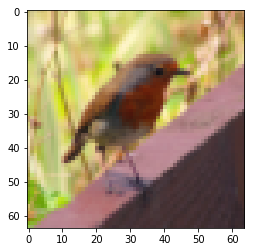

In [20]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

### Transform Data

reshape and standardize the images before feeding them to the network. 

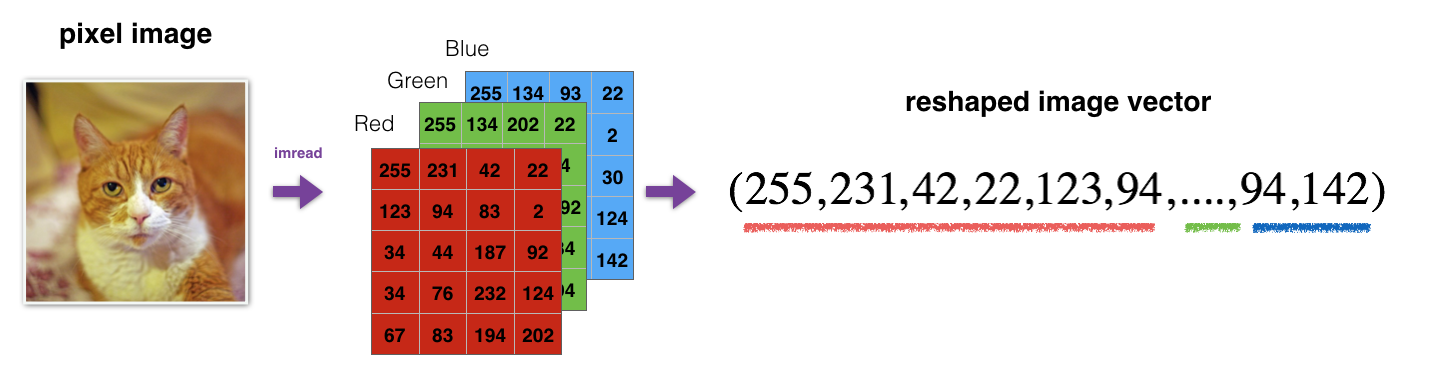

A trick  to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [21]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# Train Model

In [22]:
inputLayerSize = len(train_set_x_flatten)     # num_px * num_px * 3
outputLayerSize = 1
layers_dims = [inputLayerSize, 25,17,7, outputLayerSize]
layers_dims =[12288, 20, 7, 5, 1]
myModel = model(train_set_x, train_set_y, layers_dims = layers_dims, num_iterations = 2500, print_cost=True)

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


## Plot Learning Curve

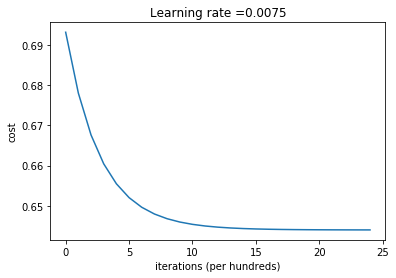

In [23]:
# Plot learning curve (with costs)
costs = np.squeeze(myModel['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(myModel["learning_rate"]))
plt.show()

# Prediction and Accuracy

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [24]:
def predict(X, y, myModel):
    m = X.shape[1]
    parameters = dict(myModel)
    del parameters["costs"]
    del parameters["learning_rate"]
   
    nLayers = len(parameters) // 2 # number of layers in the neural network
    yhat = np.zeros((1,m))
        
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)  # myModel contains parameters including cost and learning rate
        
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            yhat[0,i] = 1
        else:
            yhat[0,i] = 0
            
    return yhat


In [25]:
# Predict test/train set examples (≈ 2 lines of code)
Y_prediction_test = predict(test_set_x, test_set_y, myModel)
Y_prediction_train = predict(train_set_x, train_set_y, myModel)


# Print train/test Errors
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_set_y)) * 100))

train accuracy: 65.55023923444976 %
test accuracy: 34.0 %


# Results Analysis
Find images the model labeled incorrectly.

In [26]:
def print_mislabeled_images(classes, test_set_x, test_set_y, Y_prediction_test):
    a = Y_prediction_test + test_set_y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_set_x[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(Y_prediction_test[0,index])].decode("utf-8") 
                  + " \n Class: " + classes[test_set_y[0,index]].decode("utf-8"))

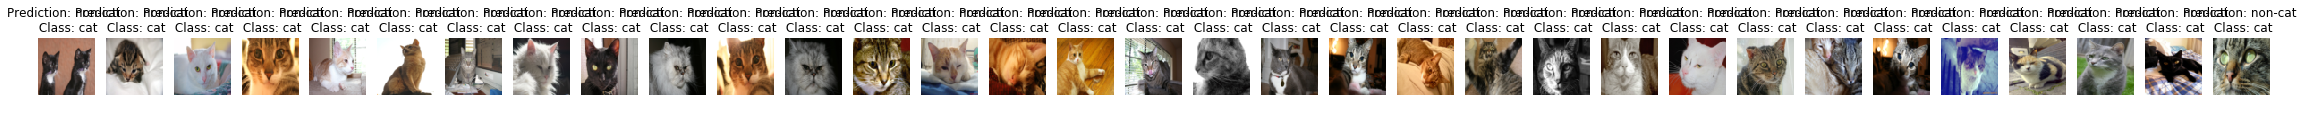

In [27]:
print_mislabeled_images(classes, test_set_x, test_set_y, Y_prediction_test)